In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

In [2]:
import acquire as a
import prepare as p

In [3]:
df = a.get_curric_data()
df.head()

,page,user_id,cohort_id,ip
time_stamp,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719459 entries, 2018-01-26 09:55:03 to 2020-11-02 16:48:47
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   page       719458 non-null  object 
 1   user_id    719459 non-null  int64  
 2   cohort_id  674619 non-null  float64
 3   ip         719459 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 27.4+ MB


In [5]:
df = p.prep_data(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 595952 entries, 2018-01-26 09:56:02 to 2020-11-02 16:48:47
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   page                     595951 non-null  object        
 1   user_id                  595952 non-null  int64         
 2   cohort_id                595952 non-null  float64       
 3   ip                       595952 non-null  object        
 4   is_ds                    595952 non-null  bool          
 5   times_accessed           595952 non-null  int64         
 6   date                     595952 non-null  datetime64[ns]
 7   name                     595952 non-null  object        
 8   start_date               595952 non-null  datetime64[ns]
 9   end_date                 595952 non-null  datetime64[ns]
 10  program_id               595952 non-null  float64       
 11  accessed_while_enrolled  595952 non-null  bo

# Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [7]:
# Shows how many times the ciriculum was accessed monthly
df[['times_accessed']].resample('m').sum().tail()

,times_accessed
date,
2020-07-31,28580
2020-08-31,25072
2020-09-30,24149
2020-10-31,22810
2020-11-30,1689


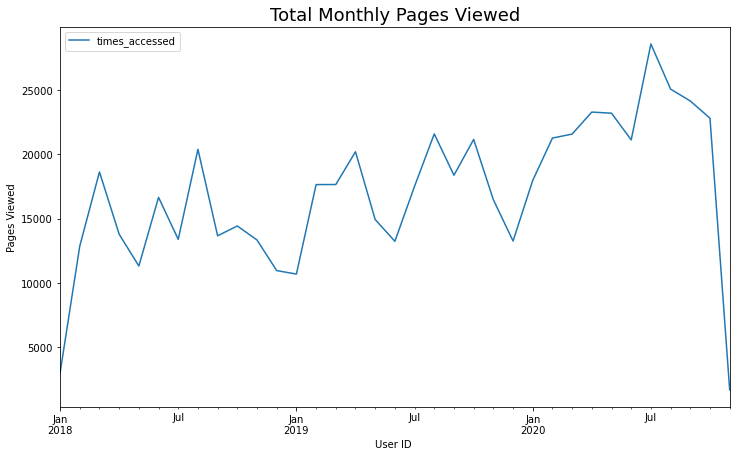

In [8]:
df[['times_accessed']].resample('m').sum().plot(figsize=(12,7))
plt.title("Total Monthly Pages Viewed", fontsize = 18)
plt.xlabel("User ID ")
plt.ylabel("Pages Viewed")
plt.show()

In [9]:
# Grouping by times accessed and cohort id
df.groupby(['times_accessed','cohort_id']).count().head()

page  user_id     ip  is_ds   date   name  \
times_accessed cohort_id                                               
1              0.0        38396    38396  38396  38396  38396  38396   
               1.0         8151     8151   8151   8151   8151   8151   
               2.0           74       74     74     74     74     74   
               4.0            3        3      3      3      3      3   
               6.0           68       68     68     68     68     68   

                          start_date  end_date  program_id  \
times_accessed cohort_id                                     
1              0.0             38396     38396       38396   
               1.0              8151      8151        8151   
               2.0                74        74          74   
               4.0                 3         3           3   
               6.0                68        68          68   

                          accessed_while_enrolled  
times_accessed cohort_id                           
1              0.0                          38396  
               1.0                           8151  
               2.0                             74  
               4.0                              3  
               6.0                             68

In [10]:
df2 = df.groupby(['page', 'cohort_id'])['times_accessed'].sum().reset_index().sort_values('times_accessed', ascending = False)
df2.head()

,page,cohort_id,times_accessed
7675,javascript-i,33.0,977
7668,javascript-i,24.0,884
7682,javascript-i,58.0,884
6796,index.html,14.0,877
7672,javascript-i,29.0,868


In [11]:
df2 = df2.sort_values(by= 'cohort_id', ascending = False)
df2.head()


,page,cohort_id,times_accessed
3056,appendix/professional-development/tech-talk,62.0,2
2978,appendix/professional-development/linkedin-tips,62.0,5
6261,html-css/bootstrap-introduction,62.0,1
3013,appendix/professional-development/professional...,62.0,4
11367,web-design/ux/layout,62.0,1


In [12]:
df2.describe()

,cohort_id,times_accessed
count,11393.000000,11393.000000
mean,27.921619,52.308523
std,18.916111,97.470937
min,0.000000,1.000000
25%,14.000000,2.000000
50%,24.000000,6.000000
75%,51.000000,53.000000
max,62.000000,977.000000


In [13]:
# Creating pages accessed data frame to see how many times ds students hit different pages

# sorting by the times accessed from highest to lowest
ds_pgs_accessed_df = df2.sort_values(by = 'times_accessed', ascending=False)

# adding mask to destinguish between ds and web_dev students
ds_pgs_accessed_df['is_ds'] = ds_pgs_accessed_df.cohort_id.isin([30,34,55,59])

# Selecting only ds students
ds_pgs_accessed_df = ds_pgs_accessed_df[ds_pgs_accessed_df.is_ds == True]

ds_pgs_accessed_df.head(10)

,page,cohort_id,times_accessed,is_ds
3285,classification/overview,59.0,759,True
136,1-fundamentals/modern-data-scientist.jpg,34.0,626,True
113,1-fundamentals/AI-ML-DL-timeline.jpg,34.0,624,True
39,1-fundamentals/1.1-intro-to-data-science,34.0,615,True
1098,6-regression/1-overview,55.0,595,True
3302,classification/scale_features_or_not.svg,59.0,590,True
1097,6-regression/1-overview,34.0,521,True
11038,sql/mysql-overview,59.0,513,True
138,1-fundamentals/modern-data-scientist.jpg,59.0,470,True
115,1-fundamentals/AI-ML-DL-timeline.jpg,59.0,470,True


## **Which lesson appears to attract the most traffic consistently across cohorts (per program)?**
For data science, the top five pages viewed across any cohort were 
1. classification/overview - cohort 59 with 759 views
2. 1-fundamentals/modern-data-scientist.jpg - cohort 34 with 626 views
3. 1-fundamentals/AI-ML-DL-timeline.jpg	- cohort 34 with 624 views
4. 1-fundamentals/1.1-intro-to-data-science	- cohort 34 with 615 views
5. 6-regression/1-overview - cohort 55 with 595 views

**ADA 30**
1. No data

**Bayes 34**
1. 1-fundamentals/modern-data-scientist.jpg - views 626
2. 1-fundamentals/AI-ML-DL-timeline.jpg - views 624
3. 1-fundamentals/1.1-intro-to-data-science - views 615

**Curie 55**
1. 6-regression/1-overview - views 595
1. 1-fundamentals/modern-data-scientist.jpg - views 467
2. 1-fundamentals/AI-ML-DL-timeline.jpg - views 465

**Darden 59**
1. classification/overview - views 759
2. classification/scale_features_or_not.svg - views 590
3. sql/mysql-overview - views 513

In [14]:
# Just ADA. No data showing in ada
#df2.sort_values(by = 'times_accessed', ascending=False)
df2.cohort_id.value_counts()

0.0     1039
22.0     528
14.0     475
34.0     448
25.0     414
55.0     396
23.0     396
17.0     380
24.0     374
61.0     370
31.0     363
59.0     348
13.0     340
1.0      339
32.0     324
18.0     314
21.0     309
29.0     306
27.0     303
33.0     294
57.0     286
26.0     277
19.0     277
8.0      275
51.0     266
58.0     265
52.0     260
56.0     257
53.0     248
15.0     229
62.0     155
16.0     131
7.0      127
12.0     115
11.0      73
6.0       44
2.0       42
9.0        3
4.0        3
Name: cohort_id, dtype: int64

In [15]:
df2 = df2[df2.page != 'search/search_index.json']

In [16]:
# Creating pages accessed data frame to see how many times ds students hit different pages

# sorting by the times accessed from highest to lowest
wdev_pgs_accessed_df = df2.sort_values(by = 'times_accessed', ascending=False)

# adding mask to destinguish between ds and web_dev students
wdev_pgs_accessed_df['is_ds'] = wdev_pgs_accessed_df.cohort_id.isin([30,34,55,59])

# Selecting only ds students
wdev_pgs_accessed_df = wdev_pgs_accessed_df[wdev_pgs_accessed_df.is_ds == False]

# Going to drop search/search_index.json as it adds no value in regards to the curriculum and
# dropping staff cohort

wdev_pgs_accessed_df = wdev_pgs_accessed_df[wdev_pgs_accessed_df.page != 'search/search_index.json']
wdev_pgs_accessed_df = wdev_pgs_accessed_df[wdev_pgs_accessed_df.cohort_id != 28]
wdev_pgs_accessed_df.head(25)

,page,cohort_id,times_accessed,is_ds
7675,javascript-i,33.0,977,False
7668,javascript-i,24.0,884,False
7682,javascript-i,58.0,884,False
6796,index.html,14.0,877,False
7672,javascript-i,29.0,868,False
7386,java-iii,24.0,770,False
7397,java-iii,53.0,767,False
7679,javascript-i,53.0,756,False
7080,java-ii,24.0,754,False
6248,html-css,33.0,753,False


## Which lesson appears to attract the most traffic consistently across cohorts (per program)? Cohort 28 is staff and makes up the majority of pages seen. Going to remove
For **WebDev**, the top five pages viewed per any cohort were 
1. javascript-i	 - cohort 33, 58, 24, & 29 with 869 - 977 views
2. index - cohort 14 with 877 views
3. java-iii	- cohort 24, 53, 29 with 742 - 770 views
4. html-css	- cohort 33 with 753 views and 56 with 708 views
5. spring - cohort 22 with 707 views and 24 & 29 with 650 views

In [17]:
df2.groupby(['cohort_id','page'])['times_accessed'].agg(['min', 'mean','max'])

min  mean  max
cohort_id page                                    
0.0       00_                         8     8    8
          00_index                   20    20   20
          01_intro                   44    44   44
          02_listing_files           39    39   39
          03_file_paths              38    38   38
...                                 ...   ...  ...
62.0      web-design                  1     1    1
          web-design/ui/color         1     1    1
          web-design/ui/typography    1     1    1
          web-design/ux/layout        1     1    1
          web-design/ux/purpose       1     1    1

[11393 rows x 3 columns]

### Takeaway: Cohort 28 had the most hits at 4633, followed by cohort 24, then darden cohort 59. 

In [18]:
my_ip = '162.197.239.66'
df[df.ip == my_ip].head()

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,accessed_while_enrolled
date,,,,,,,,,,,,
2020-07-14 15:10:04,1-fundamentals/1.1-intro-to-data-science,695,59.0,162.197.239.66,True,1,2020-07-14 15:10:04,Darden,2020-07-13,2021-01-12,3.0,True
2020-07-14 15:10:04,1-fundamentals/AI-ML-DL-timeline.jpg,695,59.0,162.197.239.66,True,1,2020-07-14 15:10:04,Darden,2020-07-13,2021-01-12,3.0,True
2020-07-14 15:10:04,1-fundamentals/modern-data-scientist.jpg,695,59.0,162.197.239.66,True,1,2020-07-14 15:10:04,Darden,2020-07-13,2021-01-12,3.0,True
2020-07-14 15:12:55,1-fundamentals/3-vocabulary,695,59.0,162.197.239.66,True,1,2020-07-14 15:12:55,Darden,2020-07-13,2021-01-12,3.0,True
2020-07-14 15:13:32,1-fundamentals/1.1-intro-to-data-science,695,59.0,162.197.239.66,True,1,2020-07-14 15:13:32,Darden,2020-07-13,2021-01-12,3.0,True


# Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over? 
- Going to compare the top five viewed cohort pages and compare to how all other cohorts viewed those pages

# Data Science

In [19]:
ds_pgs_accessed_df.head()

,page,cohort_id,times_accessed,is_ds
3285,classification/overview,59.0,759,True
136,1-fundamentals/modern-data-scientist.jpg,34.0,626,True
113,1-fundamentals/AI-ML-DL-timeline.jpg,34.0,624,True
39,1-fundamentals/1.1-intro-to-data-science,34.0,615,True
1098,6-regression/1-overview,55.0,595,True


In [20]:
ds_pgs_accessed_df[ds_pgs_accessed_df.page .isin(["classification/overview"])]

,page,cohort_id,times_accessed,is_ds
3285,classification/overview,59.0,759,True
3284,classification/overview,55.0,91,True
3283,classification/overview,34.0,10,True


### Our cohort looked at classification overview significantly more than all other cohorts.

In [21]:
ds_pgs_accessed_df[ds_pgs_accessed_df.page .isin(["1-fundamentals/modern-data-scientist.jpg"])]

,page,cohort_id,times_accessed,is_ds
136,1-fundamentals/modern-data-scientist.jpg,34.0,626,True
138,1-fundamentals/modern-data-scientist.jpg,59.0,470,True
137,1-fundamentals/modern-data-scientist.jpg,55.0,467,True


### 1-fundamentals/modern-data-scientist.jpg seemed to be evenly distributed 

In [22]:
ds_pgs_accessed_df[ds_pgs_accessed_df.page .isin(["1-fundamentals/AI-ML-DL-timeline.jpg"])]

,page,cohort_id,times_accessed,is_ds
113,1-fundamentals/AI-ML-DL-timeline.jpg,34.0,624,True
115,1-fundamentals/AI-ML-DL-timeline.jpg,59.0,470,True
114,1-fundamentals/AI-ML-DL-timeline.jpg,55.0,465,True


## 1-fundamentals/modern-data-scientist.jpg seemed to be evenly distributed

In [23]:
ds_pgs_accessed_df[ds_pgs_accessed_df.page .isin(["1-fundamentals/1.1-intro-to-data-science"])]

,page,cohort_id,times_accessed,is_ds
39,1-fundamentals/1.1-intro-to-data-science,34.0,615,True
40,1-fundamentals/1.1-intro-to-data-science,55.0,461,True
41,1-fundamentals/1.1-intro-to-data-science,59.0,460,True


## 1-fundamentals/1.1-intro-to-data-science seemed to be evenly distributed

In [24]:
ds_pgs_accessed_df[ds_pgs_accessed_df.page .isin(["6-regression/1-overview"])]

,page,cohort_id,times_accessed,is_ds
1098,6-regression/1-overview,55.0,595,True
1097,6-regression/1-overview,34.0,521,True
1099,6-regression/1-overview,59.0,7,True


### 6-regression/1-overview Darden barely accessed the regression overview unlike Bayes or Curie

In [25]:
ds_pgs_accessed_df[ds_pgs_accessed_df.page .isin(["sql/mysql-overview"])]


,page,cohort_id,times_accessed,is_ds
11038,sql/mysql-overview,59.0,513,True
11037,sql/mysql-overview,55.0,99,True
11036,sql/mysql-overview,34.0,3,True


### Darden looked at sql/mysql-overview	significantly more than Bayes and Curie

# Web Dev

In [26]:
wdev_pgs_accessed_df.head(25)

,page,cohort_id,times_accessed,is_ds
7675,javascript-i,33.0,977,False
7668,javascript-i,24.0,884,False
7682,javascript-i,58.0,884,False
6796,index.html,14.0,877,False
7672,javascript-i,29.0,868,False
7386,java-iii,24.0,770,False
7397,java-iii,53.0,767,False
7679,javascript-i,53.0,756,False
7080,java-ii,24.0,754,False
6248,html-css,33.0,753,False


In [31]:
wdev_pgs_accessed_df[wdev_pgs_accessed_df.page .isin(["javascript-i"])]

,page,cohort_id,times_accessed,is_ds
7675,javascript-i,33.0,977,False
7668,javascript-i,24.0,884,False
7682,javascript-i,58.0,884,False
7672,javascript-i,29.0,868,False
7679,javascript-i,53.0,756,False
7670,javascript-i,26.0,718,False
7677,javascript-i,51.0,696,False
7681,javascript-i,57.0,694,False
7674,javascript-i,32.0,686,False
7650,javascript-i,0.0,639,False


### javascript-i was significantly looked at less in cohorts 12, 2, 6, 15, 19, 11, 7, 13, 16, 8, 17, & 18 with a range of 1 - 128 views as opposed to cohort 33 with 977 views.

In [32]:
wdev_pgs_accessed_df[wdev_pgs_accessed_df.page .isin(["index.html"])]

,page,cohort_id,times_accessed,is_ds
6796,index.html,14.0,877,False
6795,index.html,13.0,84,False
6798,index.html,16.0,63,False
6790,index.html,0.0,54,False
6800,index.html,18.0,35,False
6799,index.html,17.0,28,False
6794,index.html,12.0,8,False
6801,index.html,19.0,6,False
6793,index.html,11.0,6,False
6802,index.html,25.0,1,False


### Cohort 14 looked at the index.html significantly more than any other cohort. Only 13 total cohorts looked at the index with cohort 13 closest at 84 views.

In [33]:
wdev_pgs_accessed_df[wdev_pgs_accessed_df.page .isin(["java-iii"])]

,page,cohort_id,times_accessed,is_ds
7386,java-iii,24.0,770,False
7397,java-iii,53.0,767,False
7390,java-iii,29.0,742,False
7384,java-iii,22.0,712,False
7393,java-iii,33.0,674,False
7400,java-iii,58.0,651,False
7399,java-iii,57.0,620,False
7398,java-iii,56.0,616,False
7395,java-iii,51.0,517,False
7388,java-iii,26.0,495,False


### java-iii was looked at significantly more in cohorts 22, 29, 24 and 53 with a range of 712 - 770. Cohorts 17, 15, 13, 62, 11, 19, 6, 12 had a range of views of 1-25.

In [34]:
wdev_pgs_accessed_df[wdev_pgs_accessed_df.page .isin(["html-css"])]

,page,cohort_id,times_accessed,is_ds
6248,html-css,33.0,753,False
6253,html-css,56.0,708,False
6245,html-css,29.0,649,False
6250,html-css,51.0,609,False
6243,html-css,26.0,587,False
6252,html-css,53.0,578,False
6240,html-css,23.0,555,False
6241,html-css,24.0,528,False
6254,html-css,57.0,472,False
6247,html-css,32.0,425,False


### html-css was looked at significantly more with cohorts 29, 33, & 56. Cohorts 7, 8, 11, 19, 13, 16, 12, 15, 2, & 6 barely looked at this page with views ranging from 1-21.

In [35]:
wdev_pgs_accessed_df[wdev_pgs_accessed_df.page .isin(["spring"])]

,page,cohort_id,times_accessed,is_ds
10566,spring,22.0,707,False
10572,spring,29.0,650,False
10568,spring,24.0,650,False
10579,spring,53.0,616,False
10580,spring,56.0,572,False
10575,spring,33.0,546,False
10577,spring,51.0,512,False
10573,spring,31.0,485,False
10581,spring,57.0,465,False
10570,spring,26.0,453,False


### spring was looked at significantly more with cohorts 22, 29, 24, & 53. Cohorts 61, 17, 15, 62, 19, 11, 13, 7, & 6 barely looked at this page with views ranging from 1-29.

# 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students? 

In [36]:
ds_cohort_list = ds_pgs_accessed_df.cohort_id.unique()
ds_cohort_list

array([59., 34., 55.])

In [37]:
# Loop for getting the top pages accessed for each cohort

top_ds = []
for c in ds_cohort_list:
    top_ds.append(ds_pgs_accessed_df[ds_pgs_accessed_df.cohort_id == c].head())
top_ds[1]

,page,cohort_id,times_accessed,is_ds
136,1-fundamentals/modern-data-scientist.jpg,34.0,626,True
113,1-fundamentals/AI-ML-DL-timeline.jpg,34.0,624,True
39,1-fundamentals/1.1-intro-to-data-science,34.0,615,True
1097,6-regression/1-overview,34.0,521,True
192,10-anomaly-detection/AnomalyDetectionCartoon.jpeg,34.0,386,True


In [38]:
#darden.groupby(['time_stamp', 'page'])['times_accessed','user_id'].agg(['min','mean','max'])

In [46]:
# Getting rid of pages that don't matter and grouping by user and cohort
df = df[df.page != 'search/search_index.json']
df.groupby(['user_id','cohort_id']).agg('sum').sort_values(by='times_accessed', ascending = True).head(10)

,,is_ds,times_accessed,program_id,accessed_while_enrolled
user_id,cohort_id,,,,
787,55.0,1,1,3.0,0
593,14.0,0,1,1.0,0
212,1.0,0,1,1.0,0
348,7.0,0,1,1.0,0
165,16.0,0,1,2.0,0
176,0.0,0,2,0.0,0
177,11.0,0,2,2.0,0
169,7.0,0,2,2.0,0
663,0.0,0,2,0.0,0


In [42]:
df[df.user_id == 787]

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,accessed_while_enrolled
date,,,,,,,,,,,,
2020-10-29 22:08:03,appendix/interview_questions_students,787,55.0,99.126.113.140,True,1,2020-10-29 22:08:03,Curie,2020-02-03,2020-07-07,3.0,False


In [44]:
df[df.user_id == 593]

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,accessed_while_enrolled
date,,,,,,,,,,,,
2020-02-17 11:45:21,index.html,593,14.0,167.24.104.150,False,1,2020-02-17 11:45:21,Lassen,2016-07-18,2016-11-10,1.0,False


In [47]:
df[df.user_id == 212]

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,accessed_while_enrolled
date,,,,,,,,,,,,
2018-06-19 09:21:08,students/units/75/sub_units/268,212,1.0,170.248.173.247,False,1,2018-06-19 09:21:08,Arches,2014-02-04,2014-04-22,1.0,False


In [48]:
df[df.user_id == 348]

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,accessed_while_enrolled
date,,,,,,,,,,,,
2019-01-27 19:02:17,content/php_iii/php-with-html/sessions-with-ph...,348,7.0,172.58.111.203,False,1,2019-01-27 19:02:17,Glacier,2015-06-05,2015-10-06,1.0,False


In [50]:
df[df.user_id == 165]

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,accessed_while_enrolled
date,,,,,,,,,,,,
2018-03-30 21:37:04,index.html,165,16.0,24.243.3.200,False,1,2018-03-30 21:37:04,Niagara,2016-10-26,2017-03-09,2.0,False


### Yes there are students who are rarely accessing the curriculum. Example, in cohorts 55 (user 787), 14 (user 593), 1 (user 212) and 7 (user 348) all accessed the curriculum one time. User 787 looked only at the appendix/interview_questions_students. User 593 and 165 looked at the index once. User 212 looked at students/units/75/sub_units/268. So it appears that one person was interested in interview questions, 2 went to the index and stopped looking, and one went to students/units/75/sub_units/268.

In [55]:
darden = df[df.cohort_id == 59]
darden.head()

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,accessed_while_enrolled
date,,,,,,,,,,,,
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,679,59.0,24.28.146.155,True,1,2020-07-13 14:39:21,Darden,2020-07-13,2021-01-12,3.0,True
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59.0,24.28.146.155,True,1,2020-07-13 14:39:36,Darden,2020-07-13,2021-01-12,3.0,True
2020-07-13 14:39:37,1-fundamentals/AI-ML-DL-timeline.jpg,679,59.0,24.28.146.155,True,1,2020-07-13 14:39:37,Darden,2020-07-13,2021-01-12,3.0,True
2020-07-13 14:39:37,1-fundamentals/modern-data-scientist.jpg,679,59.0,24.28.146.155,True,1,2020-07-13 14:39:37,Darden,2020-07-13,2021-01-12,3.0,True
2020-07-13 14:39:53,1-fundamentals/1.1-intro-to-data-science,681,59.0,108.239.188.205,True,1,2020-07-13 14:39:53,Darden,2020-07-13,2021-01-12,3.0,True


# 4. . Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses? Any odd user-agents? 

In [56]:
df.groupby(['user_id', 'page', 'cohort_id'])[['times_accessed']].agg('sum')

times_accessed
user_id page                                  cohort_id                
1       0_Classification_Algorithms           8.0                     1
        5.0_Intro_Regression                  8.0                     2
        Dataset_Challenge                     8.0                     1
        Module_6_Classification               8.0                     1
        alumni-tech-survey-2018               8.0                     2
...                                                                 ...
786     java-i/methods                        56.0                    1
        java-i/syntax-types-and-variables     56.0                    1
        java-ii                               56.0                    1
        java-ii/object-oriented-programming   56.0                    1
787     appendix/interview_questions_students 55.0                    1

[89719 rows x 1 columns]

In [57]:
# Creating pages accessed data frame to see how many times ds students hit different pages

# sorting by the times accessed from highest to lowest
ds_pgs_accessed_df = df.sort_values(by = 'times_accessed', ascending=False)

# adding mask to destinguish between ds and web_dev students
ds_pgs_accessed_df['is_ds'] = ds_pgs_accessed_df.cohort_id.isin([30,34,55,59])

# Selecting only ds students
ds_pgs_accessed_df = ds_pgs_accessed_df[ds_pgs_accessed_df.is_ds == True]

ds_pgs_accessed_df.head(10)

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,accessed_while_enrolled
date,,,,,,,,,,,,
2020-02-20 11:04:37,3-sql/5-basic-statements,590,55.0,97.105.19.58,True,1,2020-02-20 11:04:37,Curie,2020-02-03,2020-07-07,3.0,True
2020-02-20 10:58:11,3-sql/10-temporary-tables,471,34.0,173.174.248.10,True,1,2020-02-20 10:58:11,Bayes,2019-08-19,2020-01-30,3.0,False
2020-02-20 10:58:19,3-sql/7-functions,471,34.0,173.174.248.10,True,1,2020-02-20 10:58:19,Bayes,2019-08-19,2020-01-30,3.0,False
2020-02-20 10:58:43,3-sql/4-tables,471,34.0,173.174.248.10,True,1,2020-02-20 10:58:43,Bayes,2019-08-19,2020-01-30,3.0,False
2020-02-20 10:59:08,3-sql/10-temporary-tables,471,34.0,173.174.248.10,True,1,2020-02-20 10:59:08,Bayes,2019-08-19,2020-01-30,3.0,False
2020-02-20 10:15:22,3-sql/1-mysql-overview,586,55.0,97.105.19.58,True,1,2020-02-20 10:15:22,Curie,2020-02-03,2020-07-07,3.0,True
2020-02-20 10:15:30,4-python/4-control-structures,586,55.0,97.105.19.58,True,1,2020-02-20 10:15:30,Curie,2020-02-03,2020-07-07,3.0,True
2020-02-20 10:23:06,4-python/custom-sorting-functions,591,55.0,97.105.19.58,True,1,2020-02-20 10:23:06,Curie,2020-02-03,2020-07-07,3.0,True
2020-02-20 10:23:14,3-sql/1-mysql-overview,591,55.0,97.105.19.58,True,1,2020-02-20 10:23:14,Curie,2020-02-03,2020-07-07,3.0,True


In [58]:
ds_ip_list = ds_pgs_accessed_df.ip.unique()
ds_ip_list

array(['97.105.19.58', '173.174.248.10', '65.43.118.72', '67.10.169.6',
       '99.158.246.101', '72.190.169.29', '72.190.187.173',
       '107.77.221.160', '70.226.109.182', '107.77.221.127',
       '136.50.49.145', '70.123.225.30', '70.226.110.58',
       '99.126.113.140', '69.231.92.35', '107.77.217.156',
       '166.251.106.113', '75.1.166.163', '162.197.46.150',
       '166.251.101.21', '24.26.249.215', '104.5.217.57',
       '174.246.193.205', '184.226.71.155', '172.58.110.199',
       '172.58.107.245', '173.149.192.220', '172.58.107.35',
       '172.58.107.89', '72.191.48.117', '173.149.224.202',
       '166.251.101.225', '174.207.0.84', '70.94.164.83', '99.62.54.30',
       '72.177.240.51', '172.124.64.127', '173.149.239.160',
       '166.251.101.195', '70.117.71.59', '70.117.30.148',
       '70.94.160.147', '64.250.9.181', '76.185.242.211', '12.5.63.210',
       '70.123.228.86', '172.58.110.230', '104.254.95.84', '67.11.138.10',
       '70.130.127.113', '107.132.82.186', '72.1

In [59]:
y = darden.groupby(['user_id'])['times_accessed'].sum()
darden_userid_list = darden.user_id.unique()
darden_userid_list

array([679, 681, 682, 684, 680, 689, 691, 693, 692, 683, 697, 696, 694,
       686, 698, 688, 690, 685, 699, 695, 268, 687, 678, 739, 780, 783,
       781, 785])

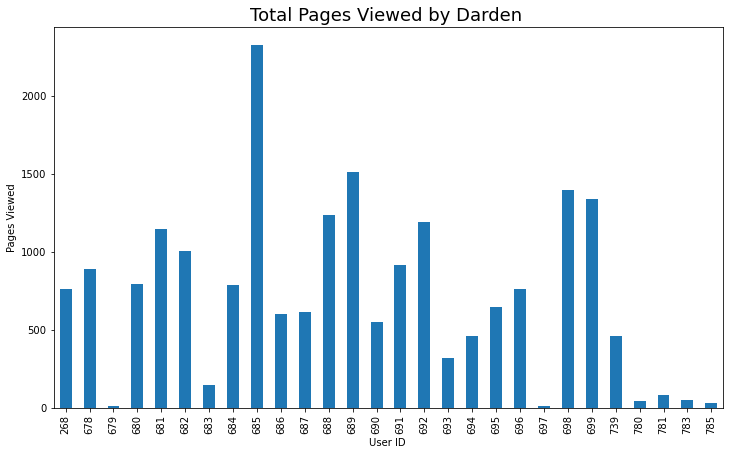

In [61]:
darden.groupby(['user_id'])['times_accessed'].sum().plot(kind='bar', figsize=(12,7))
plt.title("Total Pages Viewed by Darden", fontsize = 18)
plt.xlabel("User ID ")
plt.ylabel("Pages Viewed")
plt.show()

In [62]:
curie = df[df.cohort_id == 55]

In [63]:
df.head()

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,accessed_while_enrolled
date,,,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:02,Hampton,2015-09-22,2016-02-06,1.0,False
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:05,Hampton,2015-09-22,2016-02-06,1.0,False
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:06,Hampton,2015-09-22,2016-02-06,1.0,False
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,False,1,2018-01-26 09:56:24,Teddy,2018-01-08,2018-05-17,2.0,True
2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61,False,1,2018-01-26 09:56:41,Teddy,2018-01-08,2018-05-17,2.0,True


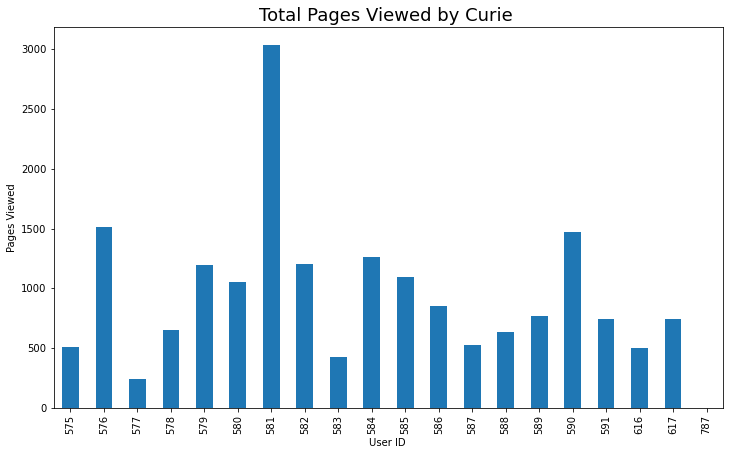

In [64]:
curie.groupby(['user_id'])['times_accessed'].sum().plot(kind='bar', figsize=(12,7))
plt.title("Total Pages Viewed by Curie ", fontsize = 18)
plt.xlabel("User ID ")
plt.ylabel("Pages Viewed")
plt.show()

In [65]:
curie[curie.user_id == 787]

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,accessed_while_enrolled
date,,,,,,,,,,,,
2020-10-29 22:08:03,appendix/interview_questions_students,787,55.0,99.126.113.140,True,1,2020-10-29 22:08:03,Curie,2020-02-03,2020-07-07,3.0,False


In [66]:
bayes = df[df.cohort_id == 34]

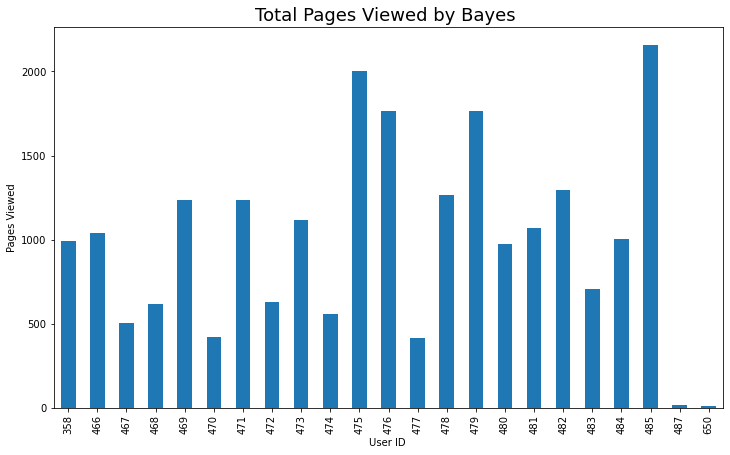

In [67]:
bayes.groupby(['user_id'])['times_accessed'].sum().plot(kind='bar', figsize=(12,7))
plt.title("Total Pages Viewed by Bayes ", fontsize = 18)
plt.xlabel("User ID ")
plt.ylabel("Pages Viewed")
plt.show()

In [68]:
# User looked strickly at appendix
bayes[bayes.user_id == 487]

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,accessed_while_enrolled
date,,,,,,,,,,,,
2019-08-30 12:02:11,appendix/cli/1-intro,487,34.0,97.105.19.58,True,1,2019-08-30 12:02:11,Bayes,2019-08-19,2020-01-30,3.0,True
2019-08-30 12:11:10,appendix/cli/2-listing-files,487,34.0,97.105.19.58,True,1,2019-08-30 12:11:10,Bayes,2019-08-19,2020-01-30,3.0,True
2019-08-30 13:37:40,appendix/cli/0-overview,487,34.0,97.105.19.58,True,1,2019-08-30 13:37:40,Bayes,2019-08-19,2020-01-30,3.0,True
2019-08-30 13:37:58,appendix/cli-git-overview,487,34.0,97.105.19.58,True,1,2019-08-30 13:37:58,Bayes,2019-08-19,2020-01-30,3.0,True
2019-08-30 14:12:22,appendix/cli/3-file-paths,487,34.0,97.105.19.58,True,1,2019-08-30 14:12:22,Bayes,2019-08-19,2020-01-30,3.0,True
2019-08-30 14:19:45,appendix/cli/4-navigating-the-filesystem,487,34.0,97.105.19.58,True,1,2019-08-30 14:19:45,Bayes,2019-08-19,2020-01-30,3.0,True
2019-08-30 14:32:22,appendix/cli/5-creating-files-and-directories,487,34.0,97.105.19.58,True,1,2019-08-30 14:32:22,Bayes,2019-08-19,2020-01-30,3.0,True
2019-08-30 14:38:57,appendix/cli/4-navigating-the-filesystem,487,34.0,97.105.19.58,True,1,2019-08-30 14:38:57,Bayes,2019-08-19,2020-01-30,3.0,True
2019-08-30 14:59:46,appendix/cli/5-creating-files-and-directories,487,34.0,97.105.19.58,True,1,2019-08-30 14:59:46,Bayes,2019-08-19,2020-01-30,3.0,True


In [69]:
bayes[bayes.user_id == 650]

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,accessed_while_enrolled
date,,,,,,,,,,,,
2020-05-07 10:35:52,appendix/professional-development/virtual-meet...,650,34.0,70.123.225.30,True,1,2020-05-07 10:35:52,Bayes,2019-08-19,2020-01-30,3.0,False
2020-06-25 10:19:01,appendix/cli-git-overview,650,34.0,70.123.225.30,True,1,2020-06-25 10:19:01,Bayes,2019-08-19,2020-01-30,3.0,False
2020-06-25 10:20:00,appendix/ds-environment-setup,650,34.0,70.123.225.30,True,1,2020-06-25 10:20:00,Bayes,2019-08-19,2020-01-30,3.0,False
2020-07-03 15:15:21,11-nlp/3-acquire,650,34.0,70.123.225.30,True,1,2020-07-03 15:15:21,Bayes,2019-08-19,2020-01-30,3.0,False
2020-07-06 11:41:32,appendix/ds-environment-setup,650,34.0,70.123.225.30,True,1,2020-07-06 11:41:32,Bayes,2019-08-19,2020-01-30,3.0,False
2020-08-09 13:18:23,python/intro-to-matplotlib,650,34.0,70.123.225.30,True,1,2020-08-09 13:18:23,Bayes,2019-08-19,2020-01-30,3.0,False
2020-08-09 14:06:52,python/intro-to-matplotlib,650,34.0,70.123.225.30,True,1,2020-08-09 14:06:52,Bayes,2019-08-19,2020-01-30,3.0,False


In [70]:
# Loop for getting the top ips accessed for each cohort

top_ds_ip = []
for x in ds_ip_list:
    top_ds_ip.append(ds_pgs_accessed_df[ds_pgs_accessed_df.ip == x].tail(20))
top_ds_ip[2]

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,accessed_while_enrolled
date,,,,,,,,,,,,
2019-11-24 18:38:51,9-timeseries/5.1-modeling-lesson1,358,34.0,65.43.118.72,True,1,2019-11-24 18:38:51,Bayes,2019-08-19,2020-01-30,3.0,True
2019-11-16 17:05:29,9-timeseries/2-acquire,358,34.0,65.43.118.72,True,1,2019-11-16 17:05:29,Bayes,2019-08-19,2020-01-30,3.0,True
2019-11-16 10:35:12,9-timeseries/3-prep,358,34.0,65.43.118.72,True,1,2019-11-16 10:35:12,Bayes,2019-08-19,2020-01-30,3.0,True
2019-11-16 10:37:56,9-timeseries/2-acquire,358,34.0,65.43.118.72,True,1,2019-11-16 10:37:56,Bayes,2019-08-19,2020-01-30,3.0,True
2019-11-16 10:38:05,9-timeseries/3-prep,358,34.0,65.43.118.72,True,1,2019-11-16 10:38:05,Bayes,2019-08-19,2020-01-30,3.0,True
2019-11-17 13:10:56,4-python/7.4-intro-to-pandas,358,34.0,65.43.118.72,True,1,2019-11-17 13:10:56,Bayes,2019-08-19,2020-01-30,3.0,True
2019-11-17 14:32:46,9-timeseries/4-explore,358,34.0,65.43.118.72,True,1,2019-11-17 14:32:46,Bayes,2019-08-19,2020-01-30,3.0,True
2019-11-17 14:35:10,9-timeseries/3-prep,358,34.0,65.43.118.72,True,1,2019-11-17 14:35:10,Bayes,2019-08-19,2020-01-30,3.0,True
2019-11-17 14:53:50,9-timeseries/4-explore,358,34.0,65.43.118.72,True,1,2019-11-17 14:53:50,Bayes,2019-08-19,2020-01-30,3.0,True


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 595952 entries, 2018-01-26 09:56:02 to 2020-11-02 16:48:47
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   page                     595951 non-null  object        
 1   user_id                  595952 non-null  int64         
 2   cohort_id                595952 non-null  float64       
 3   ip                       595952 non-null  object        
 4   is_ds                    595952 non-null  bool          
 5   times_accessed           595952 non-null  int64         
 6   date                     595952 non-null  datetime64[ns]
 7   name                     595952 non-null  object        
 8   start_date               595952 non-null  datetime64[ns]
 9   end_date                 595952 non-null  datetime64[ns]
 10  program_id               595952 non-null  float64       
 11  accessed_while_enrolled  595952 non-null  bo

In [72]:
# Creating a mask for users accessing pages after graduation for all cohorts
after_grad = df[df.accessed_while_enrolled == False]
all_after_grad =  after_grad.groupby(['user_id']).count().sort_values(by='times_accessed', ascending = False)
all_after_grad

,page,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,accessed_while_enrolled
user_id,,,,,,,,,,,
53,8126,8126,8126,8126,8126,8126,8126,8126,8126,8126,8126
64,3542,3542,3542,3542,3542,3542,3542,3542,3542,3542,3542
314,2987,2987,2987,2987,2987,2987,2987,2987,2987,2987,2987
11,2472,2472,2472,2472,2472,2472,2472,2472,2472,2472,2472
354,2167,2167,2167,2167,2167,2167,2167,2167,2167,2167,2167
...,...,...,...,...,...,...,...,...,...,...,...
348,1,1,1,1,1,1,1,1,1,1,1
394,1,1,1,1,1,1,1,1,1,1,1
415,1,1,1,1,1,1,1,1,1,1,1


In [73]:
user53 = after_grad[after_grad.user_id == 53]
user53.groupby(['page'])[['times_accessed']].count().sort_values(by='times_accessed',ascending =False)
user53.ip.value_counts()

97.105.19.58       4390
97.105.19.61       2300
67.10.174.56        704
67.10.161.55        651
192.171.117.210      35
173.175.82.174       23
173.174.212.111      17
107.77.221.110        2
98.6.52.59            2
75.54.33.178          1
72.128.136.219        1
Name: ip, dtype: int64

In [74]:
# Looking at currie
aft_grad_currie = after_grad[after_grad.cohort_id == 55]

In [75]:
# Grouping by user_id and summing the times accessed
aft_grad_currie = aft_grad_currie.groupby(['user_id']).sum().sort_values(by='times_accessed')

In [76]:
aft_grad_currie[['times_accessed']]

,times_accessed
user_id,
787,1
583,2
578,6
591,12
588,15
576,16
616,63
580,63
617,69


#### Users 581, 580 & 584 were chosen as they had the most times accessed post graduation. Looking specifically at user 581 as they had  

In [77]:
after_grad_581 = after_grad[((after_grad.user_id == 581))]

In [78]:
after_grad_581.groupby(['page']).sum().sort_values(by='times_accessed', ascending = False).head(50)

,user_id,cohort_id,is_ds,times_accessed,program_id,accessed_while_enrolled
page,,,,,,
sql/mysql-overview,36022,3410.0,62,62,186.0,0
classification/overview,32536,3080.0,56,56,168.0,0
fundamentals/AI-ML-DL-timeline.jpg,24983,2365.0,43,43,129.0,0
fundamentals/modern-data-scientist.jpg,24402,2310.0,42,42,126.0,0
fundamentals/intro-to-data-science,23240,2200.0,40,40,120.0,0
classification/scale_features_or_not.svg,20916,1980.0,36,36,108.0,0
sql/database-design,9877,935.0,17,17,51.0,0
anomaly-detection/AnomalyDetectionCartoon.jpeg,9296,880.0,16,16,48.0,0
anomaly-detection/overview,8134,770.0,14,14,42.0,0


#### Interesting find, could be some suspicious activity with the amount of access as opposed to the person next to them. This user accessed 919 pages after graduating compared to 190 who is the second highest value. There are interesting amounts of pages accessed having the same hits.

**Take a look if have time**
for x in webdev_list:
    df1 = df2_wd[df2_wd.cohort_id == x]
    if df1.date.between(df1.start_date, df1.end_date, inclusive = True).any():
        plt.figure(figsize = (10, 8))
        cohort_page_views = df1[df1.date.between(df1.start_date, df1.end_date, inclusive = True)].groupby('user_id').webpage.count()
        cohort_page_views.plot(kind = 'bar')
        low_cut = cohort_page_views.quantile(q = .1)
        plt.axhline(y = low_cut, xmin = 0, xmax = 1, linestyle = '--', label = "Botton 10%", color = "firebrick")
        plt.title(f"{x} Cohort")
        plt.xlabel("User")
        plt.legend()
        plt.show()
    else:
        print(f"No data found for {x} cohort.")

# Looking for suspect pages accessed in webdev

In [79]:
# Looking at fortuna
aft_grad_fortuna = after_grad[after_grad.cohort_id == 53]

In [80]:
# Grouping by user_id and summing the times accessed
aft_grad_fortuna = aft_grad_fortuna.groupby(['user_id']).sum().sort_values(by='times_accessed')

In [81]:
# Looking at times accessed
aft_grad_fortuna[['times_accessed']].tail()

,times_accessed
user_id,
120,99
547,173
570,309
566,425
555,510


#### Going to look at the last 2 users to see what exactly they were looking at

In [86]:
after_grad_555 = after_grad[(after_grad.user_id == 555)]

In [87]:
after_grad_555.groupby(['page']).sum().sort_values(by='times_accessed', ascending = False).head(50)

,user_id,cohort_id,is_ds,times_accessed,program_id,accessed_while_enrolled
page,,,,,,
spring,15540,1484.0,0,28,56.0,0
spring/fundamentals/controllers,13875,1325.0,0,25,50.0,0
mysql,10545,1007.0,0,19,38.0,0
java-ii,9990,954.0,0,18,36.0,0
spring/fundamentals/views,9435,901.0,0,17,34.0,0
java-iii,9435,901.0,0,17,34.0,0
spring/setup,8325,795.0,0,15,30.0,0
java-i,7770,742.0,0,14,28.0,0
spring/fundamentals/repositories,6660,636.0,0,12,24.0,0


In [88]:
after_grad_555 = after_grad_555.groupby(['page']).sum().sort_values(by='times_accessed', ascending = False).head(50)
after_grad_555.describe()

,user_id,cohort_id,is_ds,times_accessed,program_id,accessed_while_enrolled
count,50.000000,50.000000,50.0,50.000000,50.000000,50.0
mean,4195.800000,400.680000,0.0,7.560000,15.120000,0.0
std,3228.710547,308.327313,0.0,5.817496,11.634993,0.0
min,1665.000000,159.000000,0.0,3.000000,6.000000,0.0
25%,2220.000000,212.000000,0.0,4.000000,8.000000,0.0
50%,2775.000000,265.000000,0.0,5.000000,10.000000,0.0
75%,4440.000000,424.000000,0.0,8.000000,16.000000,0.0
max,15540.000000,1484.000000,0.0,28.000000,56.000000,0.0


#### Nothing looks too bad here, moving on

In [89]:
after_grad_566 = after_grad[(after_grad.user_id == 566)]

In [99]:
uni_pgs_566 = after_grad_566.groupby(['page']).sum().sort_values(by='times_accessed', ascending = False)

In [100]:
print(f'The total number of unique pages seen by user 556: {len(uni_pgs_566)}')

The total number of Webdev unique pages: 108
The total number of unique pages seen by user 556: 108


#### Overall alot of pages looked at over half. Could be normal usage?

# Going to look at an older WebDev cohort

In [92]:
# Looking at kings
aft_grad_kings = after_grad[after_grad.cohort_id == 13]

In [93]:
# Grouping by user_id and summing the times accessed
aft_grad_kings = aft_grad_kings.groupby(['user_id']).sum().sort_values(by='times_accessed')

In [94]:
# Looking at times accessed
aft_grad_kings[['times_accessed']].tail()

,times_accessed
user_id,
50,146
167,147
93,160
51,446
68,1349


#### user 68 looks suspicious with 1349 times pages accessed after graduating compared to user 51 with 446 pages accessed.

In [101]:
after_grad_68 = after_grad[(after_grad.user_id == 68)]
uni_pgs_68 = after_grad_68.groupby(['page']).sum().sort_values(by='times_accessed', ascending = False)

In [102]:
print(f'The total number of unique pages seen by user 68: {len(uni_pgs_68)}')

The total number of unique pages seen by user 68: 223


#### Shows more pages viewed than user 556. Could be normal traffic. 

In [103]:
# Creating a mask for users accessing pages after graduation

web_dev_stats = after_grad.groupby(['page']).sum().sort_values(by='times_accessed', ascending = False)
web_dev_stats

,user_id,cohort_id,is_ds,times_accessed,program_id,accessed_while_enrolled
page,,,,,,
javascript-i,1023510,65533.0,0,3180,4346.0,0
spring,732674,69047.0,0,2668,4415.0,0
html-css,755790,51001.0,0,2377,3362.0,0
java-ii,726620,50796.0,0,2255,3228.0,0
java-i,702433,52412.0,0,2222,3366.0,0
...,...,...,...,...,...,...
interview,53,14.0,0,1,1.0,0
interfaces-and-abstract-classes,779,56.0,0,1,2.0,0
html/forms,1,8.0,0,1,1.0,0


# Want to look into top usage users

In [104]:
# Looking at only web dev students that looked at curriculum after graduating
after_grad = df[df.accessed_while_enrolled == False]
after_grad = df[df.is_ds == False]
after_grad.head(1)

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,accessed_while_enrolled
date,,,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:02,Hampton,2015-09-22,2016-02-06,1.0,False


In [105]:
after_grad_stats = after_grad.groupby(['user_id'])[['times_accessed']].count()
after_grad_stats.sort_values(by = 'times_accessed', ascending = False).head()

,times_accessed
user_id,
53,8126
344,5173
570,3821
64,3555
555,3150


#### Users 53, 344, 570, 64 and 555 have the most pages viewed post graduating. User 53 has the most views and has 2800 more views than user 344 who is the second highest. Might want to look into these users more thouroughly to see if anything suspicious is going on

In [106]:
pd.set_option('display.max_rows', 500)
top_views_postgrad = after_grad[after_grad.user_id.isin([53,344,570,64])]
top_views_postgrad.groupby(['user_id','page'])[['times_accessed']].count()

times_accessed
user_id page                                                    
53      1-fundamentals/1.1-intro-to-data-science               1
        1-fundamentals/AI-ML-DL-timeline.jpg                   1
        1-fundamentals/modern-data-scientist.jpg               1
        1._Fundamentals                                        4
        10-anomaly-detection/1-overview                        1
...                                                          ...
570     spring/fundamentals/services                          13
        spring/fundamentals/views                             49
        spring/setup                                          49
        web-design/intro                                       3
        web-design/ui/typography                               1

[927 rows x 1 columns]

In [107]:
print(len(wdev_pgs_accessed_df.page.unique()))
print(len(top_views_postgrad.page.unique()))

1775
381


# 5. At some point in the last year, ability for students and alumni to cross-access curriculum (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before? 

In [108]:
ds_pgs_accessed_df.head()

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,accessed_while_enrolled
date,,,,,,,,,,,,
2020-02-20 11:04:37,3-sql/5-basic-statements,590,55.0,97.105.19.58,True,1,2020-02-20 11:04:37,Curie,2020-02-03,2020-07-07,3.0,True
2020-02-20 10:58:11,3-sql/10-temporary-tables,471,34.0,173.174.248.10,True,1,2020-02-20 10:58:11,Bayes,2019-08-19,2020-01-30,3.0,False
2020-02-20 10:58:19,3-sql/7-functions,471,34.0,173.174.248.10,True,1,2020-02-20 10:58:19,Bayes,2019-08-19,2020-01-30,3.0,False
2020-02-20 10:58:43,3-sql/4-tables,471,34.0,173.174.248.10,True,1,2020-02-20 10:58:43,Bayes,2019-08-19,2020-01-30,3.0,False
2020-02-20 10:59:08,3-sql/10-temporary-tables,471,34.0,173.174.248.10,True,1,2020-02-20 10:59:08,Bayes,2019-08-19,2020-01-30,3.0,False


In [109]:
# Going to look for key words used in both ds and webdev to see if there was cross access occuring.
ds_check = ds_pgs_accessed_df.page.str.contains('java|spring|html-css')
ds_check.value_counts()

False    61204
True        66
Name: page, dtype: int64

In [110]:
# Have to deal with nans to run code below
ds_check.fillna(True, inplace =True)

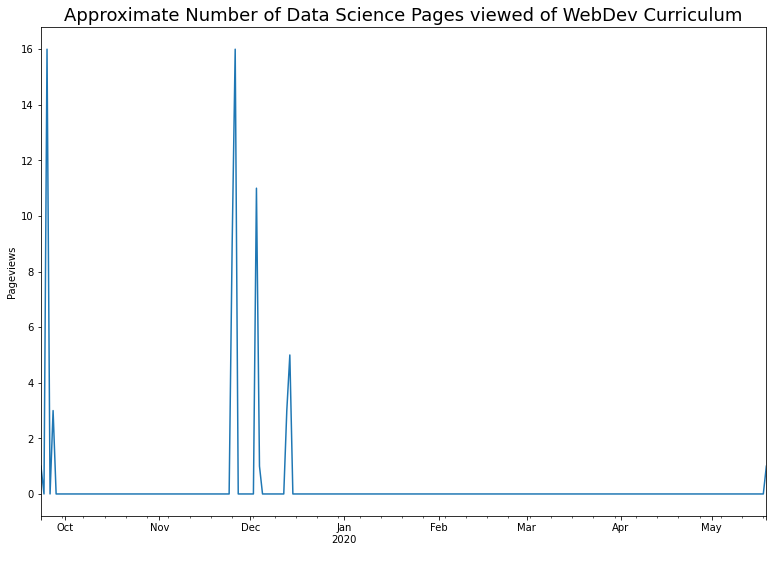

In [111]:
# Resample by day and plot to see when this was occuring.
log_ds_check = ds_pgs_accessed_df[ds_check]
log_ds_check.resample('D').page.count().plot(figsize = (13, 9))
plt.title("Approximate Number of Data Science Pages viewed of WebDev Curriculum", fontsize = 18)
plt.xlabel(" ")
plt.ylabel("Pageviews")
plt.show()



#### There was some ds students looking at the curriculum last year in Sept, Nov and Dec. There does is a hit in May of 2020. Appears cross curriculum views were shut off at the end of 2019 or the beginning of 2020. Not sure what to make of the last hit in May.

## Web dev looking at ds curriculum

In [113]:
wdev_pgs_accessed_df = df[df.cohort_id != 28]
wdev_pgs_accessed_df = df[df.is_ds == False]
wdev_pgs_accessed_df.head()

,page,user_id,cohort_id,ip,is_ds,times_accessed,date,name,start_date,end_date,program_id,accessed_while_enrolled
date,,,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:02,Hampton,2015-09-22,2016-02-06,1.0,False
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:05,Hampton,2015-09-22,2016-02-06,1.0,False
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,False,1,2018-01-26 09:56:06,Hampton,2015-09-22,2016-02-06,1.0,False
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,False,1,2018-01-26 09:56:24,Teddy,2018-01-08,2018-05-17,2.0,True
2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61,False,1,2018-01-26 09:56:41,Teddy,2018-01-08,2018-05-17,2.0,True


In [114]:
wd_check = wdev_pgs_accessed_df.page.str.contains('regression|intro-to-data-science|tableau|python|clustering|stats|classification|stats')
wd_check.value_counts()

False    533896
True        785
Name: page, dtype: int64

In [115]:
# Have to deal with nans to run code below
wd_check.fillna(True, inplace =True)

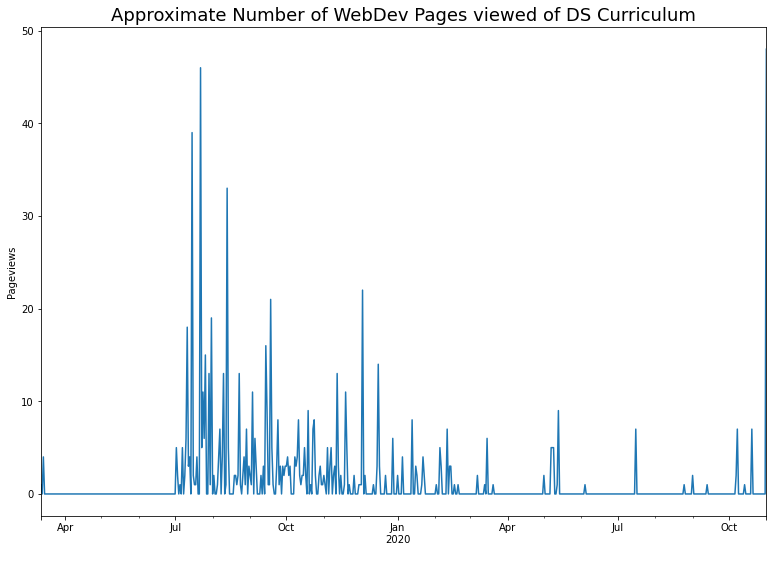

In [116]:
# Resample by day and plot to see when this was occuring. Have to deal with nans
log_wd_check = wdev_pgs_accessed_df[wd_check]
log_wd_check.resample('D').page.count().plot(figsize = (13, 9))
plt.title("Approximate Number of WebDev Pages viewed of DS Curriculum", fontsize = 18)
plt.xlabel(" ")
plt.ylabel("Pageviews")
plt.show()


#### More webdev students access the ds curriculum. There were no hits before july 2019. Hits have slowed down since jan 2020. There is still wdev students accessing the the ds curriculum in 2020 up through oct. Not sure when access was shut down.

 # What topics are grads continuing to reference after graduation and into their jobs (for each program)? 

In [117]:
# Creating a mask for users accessing pages after graduation
after_grad = df[df.accessed_while_enrolled == False]
ds_after_grad = after_grad[after_grad.is_ds == True]
ds_after_grad.groupby(['page'])[['times_accessed']].count().sort_values(by = 'times_accessed', ascending = False).head(10)

,times_accessed
page,
1-fundamentals/modern-data-scientist.jpg,104
1-fundamentals/AI-ML-DL-timeline.jpg,103
1-fundamentals/1.1-intro-to-data-science,102
sql/mysql-overview,102
classification/overview,101
6-regression/1-overview,86
10-anomaly-detection/1-overview,69
10-anomaly-detection/AnomalyDetectionCartoon.jpeg,69
fundamentals/AI-ML-DL-timeline.jpg,66


#### DS students are looking into 1-fundamentals the most with the top 3 views subsets of fundamentals. Then students are looking into sql, classification, regression, and anomaly detection.

## Webdev

In [118]:
# Creating a mask for users accessing pages after graduation
wd_after_grad = after_grad[after_grad.is_ds == False]
wd_after_grad.groupby(['page'])[['times_accessed']].count().sort_values(by = 'times_accessed', ascending = False).head(10)

,times_accessed
page,
javascript-i,3180
spring,2668
html-css,2377
java-ii,2255
java-i,2222
java-iii,2059
javascript-ii,2007
mysql,1709
jquery,1695


#### Webdev students are looking at javascript-i, spring, html-css, java-ii, and java i the most. 

# 7. Which lessons are least accessed? 

In [119]:
ds = ds_after_grad.groupby(['page'])[['times_accessed']].count().sort_values(by = 'times_accessed', ascending = False)
ds

,times_accessed
page,
1-fundamentals/modern-data-scientist.jpg,104
1-fundamentals/AI-ML-DL-timeline.jpg,103
1-fundamentals/1.1-intro-to-data-science,102
sql/mysql-overview,102
classification/overview,101
6-regression/1-overview,86
10-anomaly-detection/1-overview,69
10-anomaly-detection/AnomalyDetectionCartoon.jpeg,69
fundamentals/AI-ML-DL-timeline.jpg,66


#### While there is a lot of pages rarely accessed, tableau & various fundamentals lessons ie(/cli/creating-files-and-directories, /spreadsheets-overview)

In [120]:
wd = wd_after_grad.groupby(['page'])[['times_accessed']].count().sort_values(by = 'times_accessed', ascending = True)
wd

,times_accessed
page,
basic-statements,1
Regression_Python1,1
Regression%20_Project.md,1
Python_Libraries,1
MachineLearning_CheatSheet,1
...,...
java-i,2222
java-ii,2255
html-css,2377


#### There are hundreds of pages looked at only 1 or 2 times. Difficult to pin point what exact topics are not being utilized post graduating.